In [1]:
import numpy as np
import pandas as pd
import pyjags

import plot_utils

In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
TRACE_LENGTH = 10_000
CHAINS = 4

# Exercise 1

Reading data from csv file: 3 subjects, multiple samples per subject.

Infer the subjects proportion, individually, and compare to each other.

In [4]:
df = pd.read_csv('data/ch08_ex1_demo_data.csv', dtype={'subject': 'category'})
df.head()

,subject,y
0,moshe,1
1,moshe,1
2,moshe,0
3,moshe,0
4,moshe,1


In [5]:
df['subject'].unique()

[moshe, jacob, yossi]
Categories (3, object): [moshe, jacob, yossi]

In [6]:
code = """
model {
    for (i in 1:Ntotal) {
        y[i] ~ dbern(theta[s[i]])
    }
    for (sIdx in 1:Nsubj) {
        theta[sIdx] ~ dbeta(beta_a, beta_b)
    }
}
"""

data = {
    'beta_a': 2,
    'beta_b': 2,
    'Ntotal': len(df),
    'Nsubj': len(df['subject'].unique()),
    'y': df['y'].values,
    's': df['subject'].cat.codes.values + 1,  # Because JAGS indices start from 1
}

In [7]:
model = pyjags.Model(code=code, data=data, chains=CHAINS)

In [8]:
trace = model.sample(vars=['theta'], iterations=TRACE_LENGTH)

sampling: iterations 40000 of 40000, elapsed 0:00:00, remaining 0:00:00


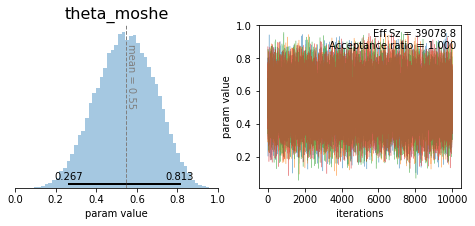

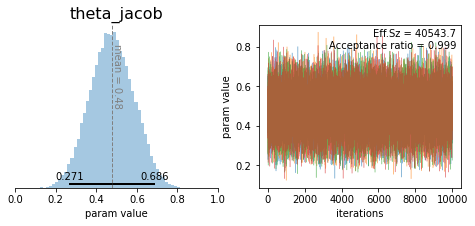

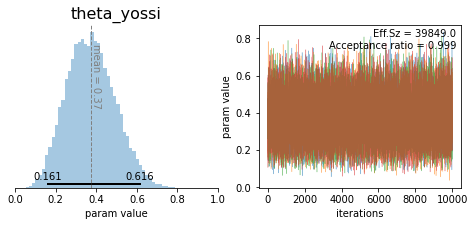

In [9]:
for t, s in zip(trace['theta'], df['subject'].unique()):
    (ax, *_) = plot_utils.dist_and_trace(t)
    ax.set_title(f'theta_{s}', fontsize=16)
    ax.set_xlim(0, 1)

# Exercise 4

Explore the priors.

In [10]:
def explore_prior(data, beta_a, beta_b):
    prior_data = data.copy()
    del prior_data['y']
    
    prior_data['beta_a'] = beta_a
    prior_data['beta_b'] = beta_b

    prior_model = pyjags.Model(code=code, data=prior_data, chains=CHAINS)

    prior_trace = prior_model.sample(vars=['theta'], iterations=TRACE_LENGTH)

    plot_utils.param_comparison(prior_trace, 'theta', [0, 1, 2])

## Question A

sampling: iterations 40000 of 40000, elapsed 0:00:00, remaining 0:00:00


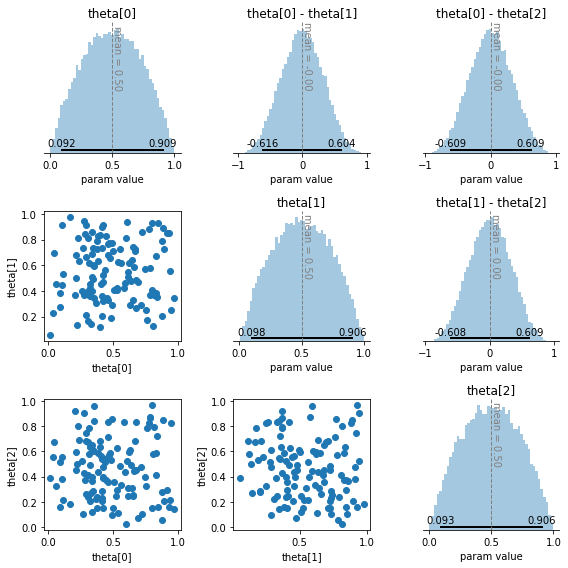

In [11]:
explore_prior(data, beta_a=2, beta_b=2)

## Question B

sampling: iterations 40000 of 40000, elapsed 0:00:00, remaining 0:00:00


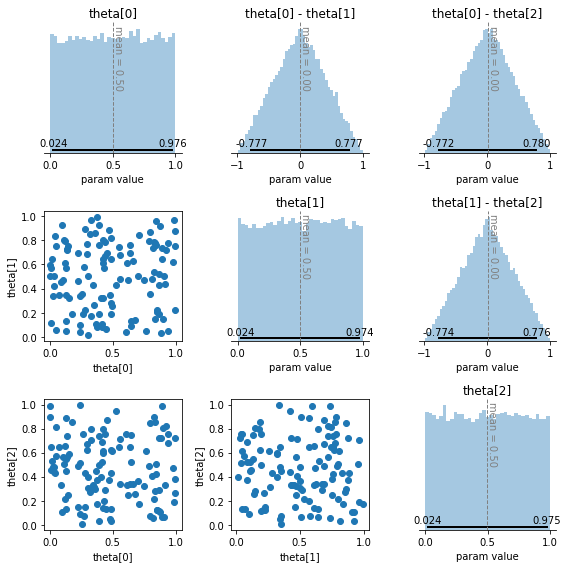

In [12]:
explore_prior(data, beta_a=1, beta_b=1)

## Question C

sampling: iterations 40000 of 40000, elapsed 0:00:00, remaining 0:00:00


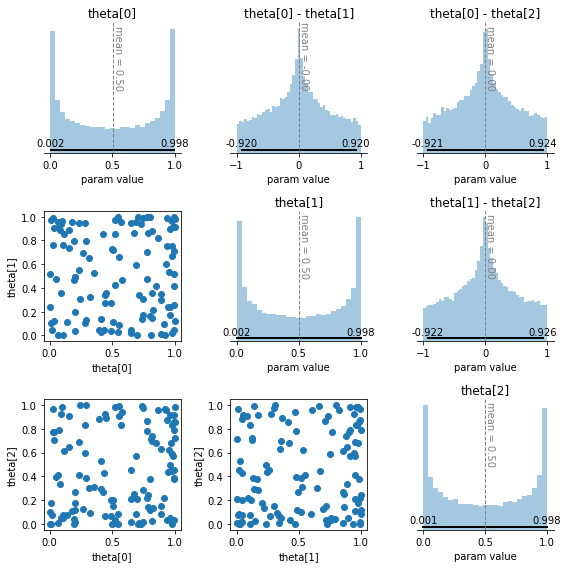

In [13]:
explore_prior(data, beta_a=0.5, beta_b=0.5)